In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
import sklearn as sk

# Reading in the Data

In [2]:
data = pd.read_csv("Data/Train.csv")
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [3]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


# Exploratory Analysis

## Survival Counts

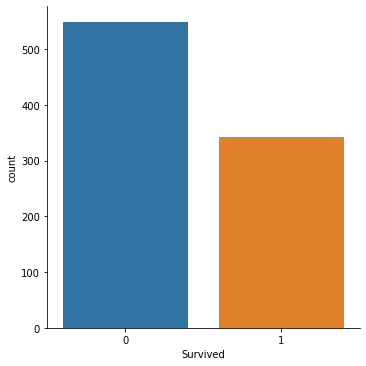

In [4]:
sns.catplot(x="Survived", kind="count", data=data)

## Survival with respect to Age

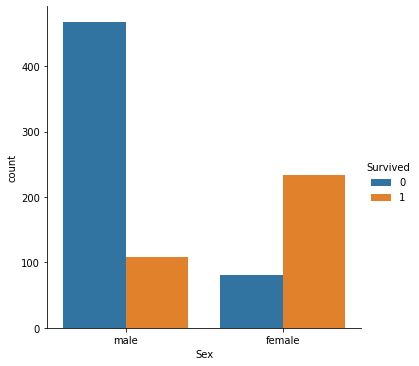

In [5]:
sns.catplot(x="Sex", hue="Survived", kind="count", data=data)

## Does age impact survival chances?

In [ ]:
data["AgeCat"] = data.apply(
    lambda row: 5 if np.isnan(row["Age"]) else row["Age"] // 5,
    axis = 1
).astype(int)
sns.catplot(x="AgeCat", hue="Survived", kind="count", data=data)

Seperated the ages into by years of 5, since the age varies much. It seems some age groups have better survival chances compared to others

## Does class impact survival chances?

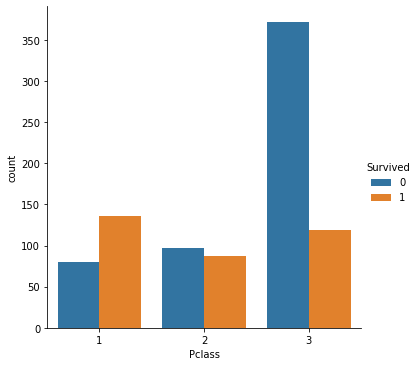

In [7]:
sns.catplot(x="Pclass", hue="Survived", kind="count", data=data)

People who lived in first classed had a better survival chance, while people in 3rd class had the worst!

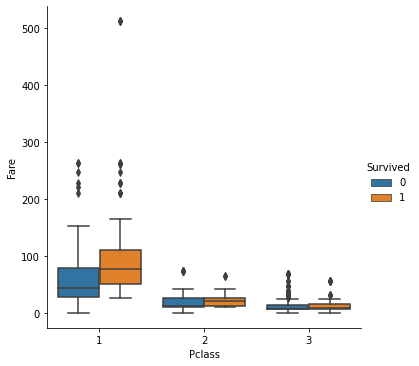

In [8]:
sns.catplot(x="Pclass", y="Fare", hue="Survived", kind="box", data=data)

Its obvious that fare would be correlated with class. It does seem like those who paid a higher fare in first class had a better survival chance

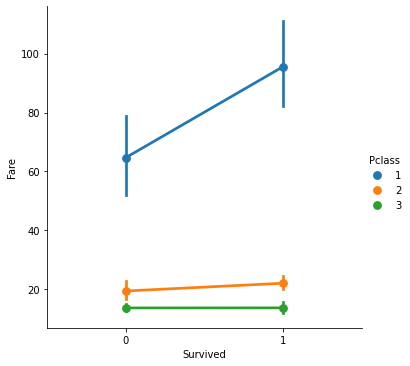

In [9]:
sns.catplot(x="Survived", y="Fare", hue="Pclass", kind="point", data=data)

The vertical lines are confidence intervals, so it does seem like fare can make a difference within first class

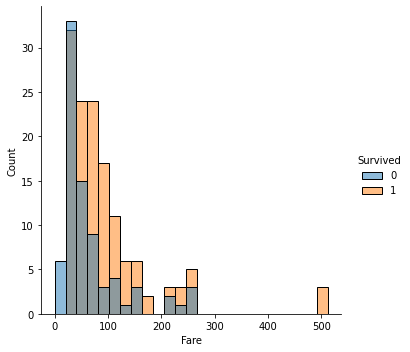

In [10]:
sns.displot(x="Fare", hue="Survived", data=data[data["Pclass"] == 1])

Its much easier to see in the distribution

In [11]:
def calc_conf_interval_of_survival(data, feature):
    survived = data[data["Survived"] == 1][feature]
    not_survived = data[data["Survived"] == 0][feature]
    averages = []
    for i in range(len(data)*10):
        survived_sample = survived.sample(len(survived)//2, replace=True)
        not_survived_sample = not_survived.sample(len(not_survived)//2, replace=True)

        averages.append(np.average(survived_sample) - np.average(not_survived_sample))
    return (np.percentile(averages, 2.5), np.percentile(averages, 97.5))
print(f"Diff Conf. Interval {calc_conf_interval_of_survival(data[data['Pclass'] == 1], 'Fare')}")

Diff Conf. Interval (4.304883639705883, 59.991226742647086)


We can use bootstrap to take a confidence interval, we are able to see 95% confidence interval of the difference of means. Since 0 is not within this interval, it is statistically significant that the fare makes a difference in surivial for 1st class! Lets make another class so we can further tell the model who will have a higher chance of survival.

In [12]:
def calc_conf_interval(data, feature):
    feature = data[feature]
    averages = []
    for i in range(len(data)*10):
        sample = feature.sample(len(feature)//2, replace=True)

        averages.append(np.average(sample))
    return (np.percentile(averages, 2.5), np.percentile(averages, 97.5))
calc_conf_interval(data[(data["Pclass"] == 1) & (data["Survived"] == 1)], "Fare")


(77.14403433823529, 117.10947507352934)

Creating a super rich class based on this lower conf interval

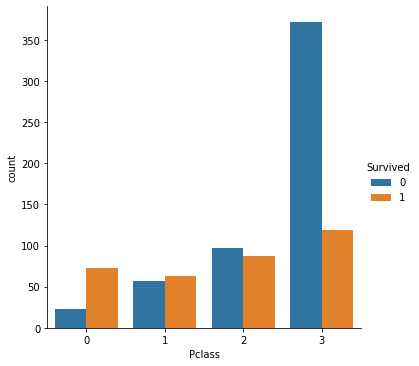

In [13]:
data["Pclass"] = data.apply(
    lambda row: 0 if row["Fare"] > 76 else row["Pclass"],
    axis=1
)
sns.catplot(x="Pclass", hue="Survived", kind="count", data=data)

More clear surivival for 0 compared to the old 1

In [14]:
data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

## Does embarked makes a difference?

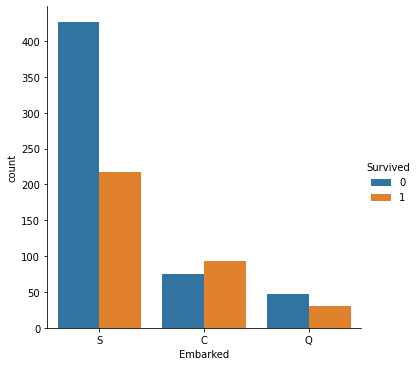

In [15]:
sns.catplot(x="Embarked", hue="Survived", kind="count", data=data)

Intresting how people that came from S had worst survival rates, why?

## Does the amount of relatives make a difference?

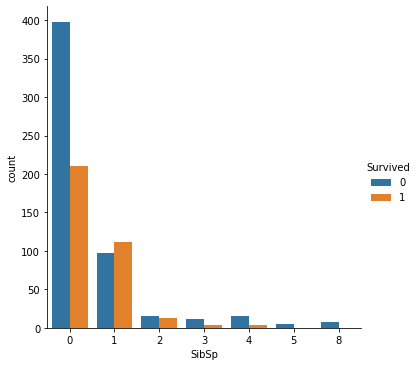

In [16]:
sns.catplot(x="SibSp", hue="Survived", kind="count", data=data)

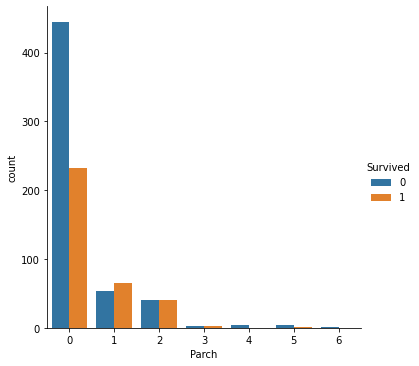

In [17]:
sns.catplot(x="Parch", hue="Survived", kind="count", data=data)

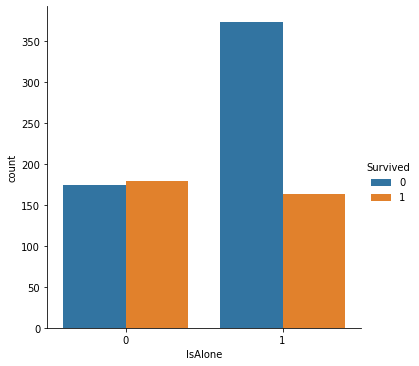

In [18]:
data["IsAlone"] = data.apply(
    lambda row: 1 if row["SibSp"] == 0 and row["Parch"] == 0 else 0,
    axis=1
) # Adds the is alone
sns.catplot(x="IsAlone", hue="Survived", kind="count", data=data)

It seems like being alone gives a more worst chance of survival

# Feature Extraction: Title

In [19]:
title_counts = data.apply(
    lambda row: row["Name"].split()[1],
    axis=1
).value_counts() # Adds the title
title_counts = title_counts[title_counts > 5]
title_counts

Mr.        502
Miss.      179
Mrs.       121
Master.     40
Dr.          7
Rev.         6
dtype: int64

In [20]:
data["Title"] = data.apply(
    lambda row: row["Name"].split()[1] if row["Name"].split()[1] in title_counts else "Rare",
    axis=1
)
data["Title"]

0        Mr.
1       Mrs.
2      Miss.
3       Mrs.
4        Mr.
       ...  
886     Rev.
887    Miss.
888    Miss.
889      Mr.
890      Mr.
Name: Title, Length: 891, dtype: object

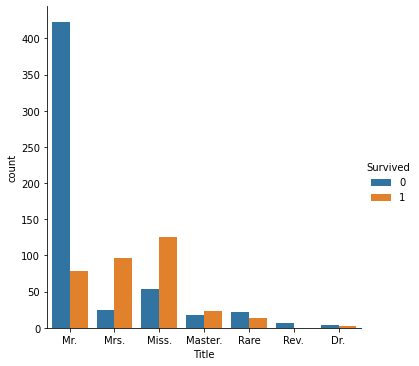

In [21]:
sns.catplot(x="Title", hue="Survived", kind="count", data=data)

Obvious for the onces where gender is correclated with (Mr. Mrs. and Miss.)

# Data Cleaning and Preparing for Model

Somes notes about cleaning:

- For when Empty Titles Embarkes have their own category
- After fine tuning model, it turns out that Sex could be replaced with Title (because of Mr. Mrs. and Miss.)
- Also, it turns out IsAlone is not significant
- Fare can be omit due to its spread within Class
- All explainatory variables end up being categorical

In [22]:
def clean_data(data):
    clean = data.copy()
    cleanup_cats = {
        "Sex": {"male": 0, "female":1}, 
        "Embarked": {"S": 0, "C": 1, "Q": 2},
        "Title": {"Mr.": 0, "Miss.": 1, "Mrs.": 2, "Master.": 3, "Dr.": 4, "Rev.": 5, "Rare": 6}
    }
    clean = clean.replace(cleanup_cats)

    clean["Embarked"] = clean.apply(
        lambda row: 3 if np.isnan(row["Embarked"]) else row["Embarked"],
        axis=1
    ).astype(int)

    return clean
clean = clean_data(data)
Y = clean["Survived"]
X = clean.drop(columns=["Survived"])
drop_cols = ["PassengerId", "SibSp", "Parch", "Fare", "Name", "Ticket", "Cabin", "Age", "IsAlone", "Sex"] # What we dont want
X = X.drop(columns=drop_cols)
X

,Pclass,Embarked,AgeCat,Title
0,3,0,5,0
1,1,1,8,2
2,3,0,6,1
3,1,0,8,2
4,3,0,8,0
...,...,...,...,...
886,2,0,6,5
887,1,0,4,1
888,3,0,0,1
889,1,1,6,0


# Model Building

Through using a variety of models, using gradient boosting on decision trees seem to give me the best result

In [23]:
model = CatBoostClassifier(num_trees=700, max_depth=10, learning_rate=0.005)

For model validation, we are using bootstrap sampling to generate average accuracy and confidence interval using a 80/20 train-test sample

In [24]:
accuracy = []

# Bootstrap
for i in range(100):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
    model.fit(X_train, Y_train, silent=True)
    Y_hat = model.predict(X_test)
    cm = confusion_matrix(Y_test, Y_hat)
    accuracy.append(cm.trace() / len(X_test))
print(f"Avg: {np.average(accuracy)}")
print(f"Std: {np.std(accuracy)}")
accuracy_ci = (np.percentile(accuracy, 2.5), np.percentile(accuracy, 97.5))
print(f"Conf. Interval: {accuracy_ci}")

Avg: 0.8154748603351956
Std: 0.026173109829792
Conf. Interval: (0.7624301675977654, 0.8603351955307262)


Histogram of accuracy

(array([ 6.,  3.,  9., 11., 15., 16., 16., 12.,  8.,  4.]),
 array([0.75418994, 0.76592179, 0.77765363, 0.78938547, 0.80111732,
        0.81284916, 0.82458101, 0.83631285, 0.84804469, 0.85977654,
        0.87150838]),
 <BarContainer object of 10 artists>)

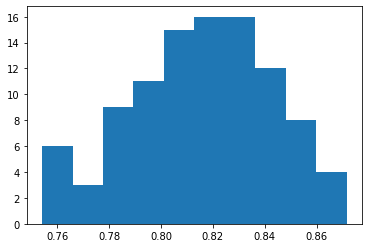

In [25]:
plt.hist(accuracy)

Confusion matrix of final trial

In [26]:
cm

array([[108,   9],
       [ 20,  42]], dtype=int64)

Plots importances from the model. Title is the most important due its ability to seperate sex, followed by class

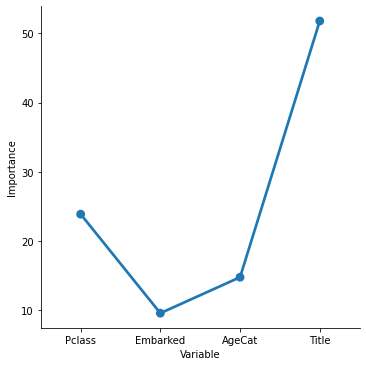

In [27]:
importances = pd.DataFrame(np.transpose([model.feature_importances_, X.columns]), columns=["Importance", "Variable"])
importances
sns.catplot(x="Variable", y="Importance", kind="point", data=importances)

Creating Submission Results for Kaggle

In [28]:
model.fit(X, Y, silent=True)
test_data = pd.read_csv("Data/test.csv")
test_data["Pclass"] = test_data.apply(
    lambda row: 0 if row["Fare"] > 76 else row["Pclass"],
    axis=1
)
test_data["Title"] = test_data.apply(
    lambda row: row["Name"].split()[1] if row["Name"].split()[1] in title_counts else "Rare",
    axis=1
)
test_data["AgeCat"] = test_data.apply(
    lambda row: 5 if np.isnan(row["Age"]) else row["Age"] // 5,
    axis = 1
).astype(int)
test_data["IsAlone"] = test_data.apply(
    lambda row: 1 if row["SibSp"] == 0 and row["Parch"] == 0 else 0,
    axis=1
) # Adds the is alone
X_test = clean_data(test_data)
X_test = X_test.drop(columns=drop_cols)
Y_hat = model.predict(X_test)
result = test_data.copy()
result["Survived"] = Y_hat
result[["PassengerId", "Survived"]].to_csv("submission.csv", index=None)